In [1]:
import shelve
import snowballstemmer
from stop_words import get_stop_words
import re
from sklearn.feature_extraction.text import CountVectorizer
import joblib
from collections import Counter
import pandas as pd

def separate_articles_by_language(article_db):
    article_db_french = {}
    article_db_english = {}

    for article_id, article in article_db.items():
        language = article.get('Langue', '').lower()
        if language == 'fr':
            article_db_french[article_id] = article
        elif language == 'en':
            article_db_english[article_id] = article

    return article_db_french, article_db_english

def process_articles(article_db, stopwords, stemmer):
    all_processed_texts = []

    for article_id, article in article_db.items():
        title = article.get('Titre', '')
        description = article.get('Description / Résumé', '')
        content = article.get('Contenu', '')

        # Combine the values and print
        combined_text = f"{title} {description} {content}"

        # Remove punctuation, make lowercase, and remove numbers
        text_without_punctuation = re.sub(r'[^\w\s]', '', combined_text)
        text_lower = text_without_punctuation.lower()
        text_without_numbers = re.sub(r'\d+', '', text_lower)

        # Tokenize the text and perform stemming
        words = text_without_numbers.split()
        filtered_words = [word for word in words if word.lower() not in stopwords]
        stemmed_words = [stemmer.stemWord(word) for word in filtered_words]

        # Combine the stemmed words into a string for CountVectorizer
        processed_text = ' '.join(stemmed_words)

        # Append processed text to the list
        all_processed_texts.append(processed_text)

    return all_processed_texts

def save_and_load_data(vectorizer, sparse_matrix, filename_feature, filename_matrix):
    # Save feature names and sparse matrix into two files
    joblib.dump(vectorizer.get_feature_names_out(), filename_feature)
    joblib.dump(sparse_matrix, filename_matrix)

    # Load feature names and sparse matrix back into memory
    loaded_feature_names = joblib.load(filename_feature)
    loaded_sparse_matrix = joblib.load(filename_matrix)

    return loaded_feature_names, loaded_sparse_matrix

def calculate_word_occurrences(feature_names, sparse_matrix):
    total_word_occurrences = Counter()
    for row in sparse_matrix:
        total_word_occurrences += Counter({feature: count for feature, count in zip(feature_names, row.toarray()[0])})

    return total_word_occurrences

def display_word_occurrences(word_occurrences):
    # Display the total occurrences of each word with more than 100 occurrences, sorted by count in descending order
    print("\nTotal Word Occurrences Across All Articles (with more than 100 occurrences), sorted by count:")

    # Sort the total_word_occurrences dictionary by count in descending order
    sorted_word_occurrences = sorted(word_occurrences.items(), key=lambda x: x[1], reverse=False)

    # Display sorted results
    for word, count in sorted_word_occurrences:
        print(f"{word}: {count}")

def create_dataset(article_db, stopwords, stemmer, vectorizer, filename_feature, filename_matrix, language):
    all_processed_texts = process_articles(article_db, stopwords, stemmer)
    all_sparse_matrix = vectorizer.transform(all_processed_texts)
    loaded_feature_names, loaded_sparse_matrix = save_and_load_data(vectorizer, all_sparse_matrix, filename_feature,
                                                                   filename_matrix)
    total_word_occurrences = calculate_word_occurrences(loaded_feature_names, loaded_sparse_matrix)

    result_list = []

    for article_id, article in article_db.items():
        title = article.get('Titre', '')
        description = article.get('Description / Résumé', '')
        content = article.get('Contenu', '')
        combined_text = f"{title} {description} {content}"
        text_without_punctuation = re.sub(r'[^\w\s]', '', combined_text)
        text_lower = text_without_punctuation.lower()
        text_without_numbers = re.sub(r'\d+', '', text_lower)
        words = text_without_numbers.split()
        filtered_words = [word for word in words if word.lower() not in stopwords]
        stemmed_words = [stemmer.stemWord(word) for word in filtered_words]
        processed_text = ' '.join(stemmed_words)
        word_occurrences_dict = {word: total_word_occurrences[word] for word in processed_text.split()}

        category = article.get('Catégorie', '')



        result_list.append({'document': article_id, 'word_occurrences': word_occurrences_dict,
                            'catégorie': category })

    result_dataset = pd.DataFrame(result_list)
    return result_dataset

# Language settings
lang_french = "french"
lang_english = "english"

# Snowball stemmers and stop words
stemmer_french = snowballstemmer.stemmer(lang_french)
stopwords_french = get_stop_words(lang_french)

stemmer_english = snowballstemmer.stemmer(lang_english)
stopwords_english = get_stop_words(lang_english)

# Open the shelve file for reading
article_db = shelve.open('../items4/article_db', 'r')

# Separate articles by language
article_db_french, article_db_english = separate_articles_by_language(article_db)

# Close the shelve file when done
article_db.close()

# Use CountVectorizer directly on processed texts for each language
vectorizer_french = CountVectorizer(stop_words=stopwords_french)
all_processed_texts_french = process_articles(article_db_french, stopwords_french, stemmer_french)
all_sparse_matrix_french = vectorizer_french.fit_transform(all_processed_texts_french)

vectorizer_english = CountVectorizer(stop_words=stopwords_english)
all_processed_texts_english = process_articles(article_db_english, stopwords_english, stemmer_english)
all_sparse_matrix_english = vectorizer_english.fit_transform(all_processed_texts_english)




# Create dataset for French
dataset_french = create_dataset(article_db_french, stopwords_french, stemmer_french, vectorizer_french,
                                'feature_names_french.joblib', 'sparse_matrix_french.joblib', lang_french)

# Create dataset for English
dataset_english = create_dataset(article_db_english, stopwords_english, stemmer_english, vectorizer_english,
                                 'feature_names_english.joblib', 'sparse_matrix_english.joblib', lang_english)

# Display the datasets
print("\nDataset for French:")
print(dataset_french.head())

print("\nDataset for English:")
print(dataset_english.head())


c:\Users\samue\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(



Dataset for French:
                           document  \
0  cc9fcfe9e486c4eea058a446dd1e0db2   
1  c072c83cbcf17a654462dd72537f27dd   
2  332cc3c51f193102db3b5047fd32c5e9   
3  8b9e241396f9b354888483842891d4f1   
4  b053ab2421494c97abfe4ee48418252e   

                                    word_occurrences  \
0  {'milwauke': 1, 'dancing': 1, 'grann': 1, 'pla...   
1  {'pel': 6, 'lif': 2, 'in': 26, 'pictur': 1, 'b...   
2  {'tony': 4, 'finaus': 1, 'quest': 4, 'for': 14...   
3  {'biden': 11, 'bolster': 1, 'union': 5, 'suppo...   
4  {'sport': 19, 'lécol': 29, 'minister': 39, 'lé...   

                                     catégorie  
0  POLITIQUE-GEOPOLITIQUE/POLITICS-GEOPOLITICS  
1                                  SPORT/SPORT  
2                                  SPORT/SPORT  
3             FINANCE-ECONOMIE/FINANCE-ECONOMY  
4                                  SPORT/SPORT  

Dataset for English:
                           document  \
0  b318d6f5cba359c27e78cd185836dfe4   
1  e865f7e75d

In [2]:
dataset_french

,document,word_occurrences,catégorie
0,cc9fcfe9e486c4eea058a446dd1e0db2,"{'milwauke': 1, 'dancing': 1, 'grann': 1, 'pla...",POLITIQUE-GEOPOLITIQUE/POLITICS-GEOPOLITICS
1,c072c83cbcf17a654462dd72537f27dd,"{'pel': 6, 'lif': 2, 'in': 26, 'pictur': 1, 'b...",SPORT/SPORT
2,332cc3c51f193102db3b5047fd32c5e9,"{'tony': 4, 'finaus': 1, 'quest': 4, 'for': 14...",SPORT/SPORT
3,8b9e241396f9b354888483842891d4f1,"{'biden': 11, 'bolster': 1, 'union': 5, 'suppo...",FINANCE-ECONOMIE/FINANCE-ECONOMY
4,b053ab2421494c97abfe4ee48418252e,"{'sport': 19, 'lécol': 29, 'minister': 39, 'lé...",SPORT/SPORT
...,...,...,...
900,b6af983d2c715a2f19407785332dd6e4,"{'myster': 16, 'cercl': 46, 'fé': 34, 'air': 2...",SCIENCE/SCIENCE
901,228d0fa732e91abd188fc6283b2a2e5c,"{'décollag': 10, 'starship': 51, 'explos': 27,...",SCIENCE/SCIENCE
902,6d2d400231379648e2a50c1e8654c61f,"{'insect': 31, 'nuisibl': 13, 'scientif': 201,...",SCIENCE/SCIENCE
903,c49e8e6514c14f24587cbc0b042cb1ac,"{'soulag': 25, 'lanxiet': 13, 'dentist': 16, '...",SCIENCE/SCIENCE


In [3]:
dataset_english

,document,word_occurrences,catégorie
0,b318d6f5cba359c27e78cd185836dfe4,"{'still': 312, 'havent': 19, 'file': 51, 'tax'...",POLITIQUE-GEOPOLITIQUE/POLITICS-GEOPOLITICS
1,e865f7e75da17823cb86215d36781cf7,"{'retail': 36, 'spend': 116, 'fell': 30, 'marc...",POLITIQUE-GEOPOLITIQUE/POLITICS-GEOPOLITICS
2,b1988a7ccf8b1f6468c2028cc1e08d8f,"{'analysi': 40, 'fox': 29, 'news': 886, 'enter...",POLITIQUE-GEOPOLITIQUE/POLITICS-GEOPOLITICS
3,d3e6aae65bbb462b485847a08f8e99a7,"{'silicon': 12, 'valley': 23, 'bank': 132, 'co...",POLITIQUE-GEOPOLITIQUE/POLITICS-GEOPOLITICS
4,054e8a0307d0d9b661b6feac47df1b1d,"{'lake': 57, 'powel': 30, 'water': 175, 'level...",POLITIQUE-GEOPOLITIQUE/POLITICS-GEOPOLITICS
...,...,...,...
1273,1065fc650426546da8dd75e85b0f1bf3,"{'nfl': 31, 'report': 425, 'charissa': 3, 'tho...",ART & CULTURE/ART
1274,c0ba7f59285f44d4ec7cdeeeed92649c,"{'yet': 118, 'anoth': 184, 'colleg': 47, 'cour...",ART & CULTURE/ART
1275,438078e53480b96153a8a8b50567dcd1,"{'la': 96, 'affair': 48, 'broke': 35, 'wrote':...",SANTE-MEDECINE/HEALTH
1276,a87039b7abcc6d23527a447b228d3bd8,"{'spacex': 8, 'starship': 9, 'second': 195, 'u...",FINANCE-ECONOMIE/FINANCE-ECONOMY


c:\Users\samue\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\samue\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

            Classifier  Accuracy
0                 k-NN  0.408840
1  Logistic Regression  0.602210
2          Naive Bayes  0.585635
3                  SVM  0.403315
4       Neural Network  0.574586
5        Random Forest  0.734807


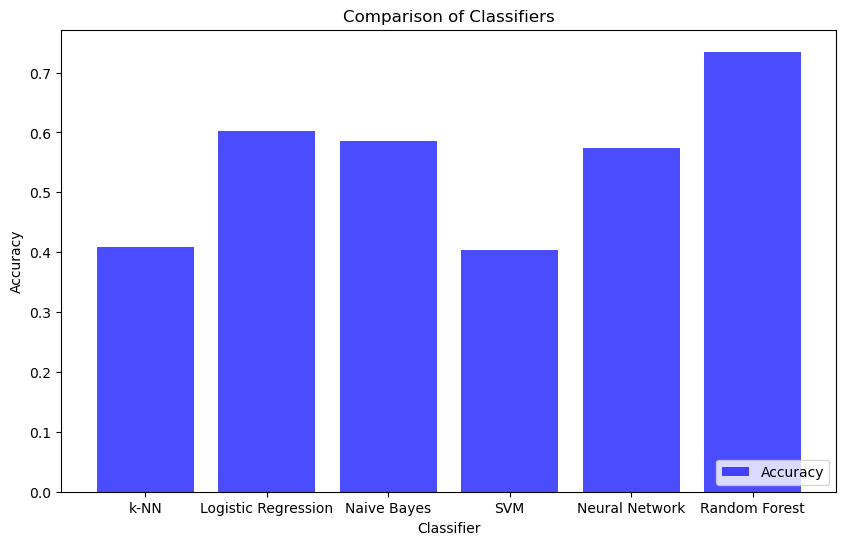

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Charger le dataset (assurez-vous que dataset_french est correctement défini)
df = dataset_french

# Diviser le dataset en features (X) et la target (y)
X = df['word_occurrences']
y = df['catégorie']

# Convertir les occurrences de mots en vecteurs
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(X)

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser les classifieurs
classifiers = {
    'k-NN': KNeighborsClassifier(n_neighbors=3),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Comparaison des classifieurs avec validation croisée
results = {'Classifier': [], 'Accuracy': []}

# Définir une stratégie de validation croisée (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for clf_name, clf in classifiers.items():
    # Entraîner le classifieur sur l'ensemble d'entraînement
    clf.fit(X_train, y_train)
    
    # Évaluer le classifieur sur l'ensemble de test
    accuracy = clf.score(X_test, y_test)
    
    # Stocker les résultats
    results['Classifier'].append(clf_name)
    results['Accuracy'].append(accuracy)

# Afficher les résultats
results_df = pd.DataFrame(results)
print(results_df)

# Visualisation des résultats avec des barres
plt.figure(figsize=(10, 6))
plt.bar(results_df['Classifier'], results_df['Accuracy'], color='blue', alpha=0.7, label='Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifiers')
plt.legend(loc='lower right')
plt.show()


c:\Users\samue\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\samue\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

            Classifier  Accuracy
0                 k-NN  0.589844
1  Logistic Regression  0.671875
2          Naive Bayes  0.468750
3                  SVM  0.601562
4       Neural Network  0.734375
5        Random Forest  0.726562


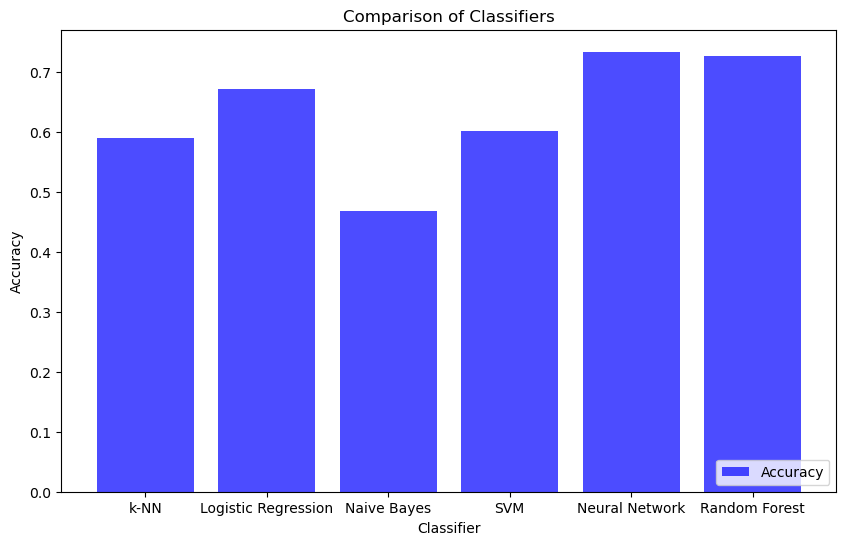

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Charger le dataset (assurez-vous que dataset_french est correctement défini)
df = dataset_english

# Diviser le dataset en features (X) et la target (y)
X = df['word_occurrences']
y = df['catégorie']

# Convertir les occurrences de mots en vecteurs
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(X)

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser les classifieurs
classifiers = {
    'k-NN': KNeighborsClassifier(n_neighbors=3),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Comparaison des classifieurs avec validation croisée
results = {'Classifier': [], 'Accuracy': []}

# Définir une stratégie de validation croisée (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for clf_name, clf in classifiers.items():
    # Entraîner le classifieur sur l'ensemble d'entraînement
    clf.fit(X_train, y_train)
    
    # Évaluer le classifieur sur l'ensemble de test
    accuracy = clf.score(X_test, y_test)
    
    # Stocker les résultats
    results['Classifier'].append(clf_name)
    results['Accuracy'].append(accuracy)

# Afficher les résultats
results_df = pd.DataFrame(results)
print(results_df)

# Visualisation des résultats avec des barres
plt.figure(figsize=(10, 6))
plt.bar(results_df['Classifier'], results_df['Accuracy'], color='blue', alpha=0.7, label='Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifiers')
plt.legend(loc='lower right')
plt.show()


c:\Users\samue\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\samue\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

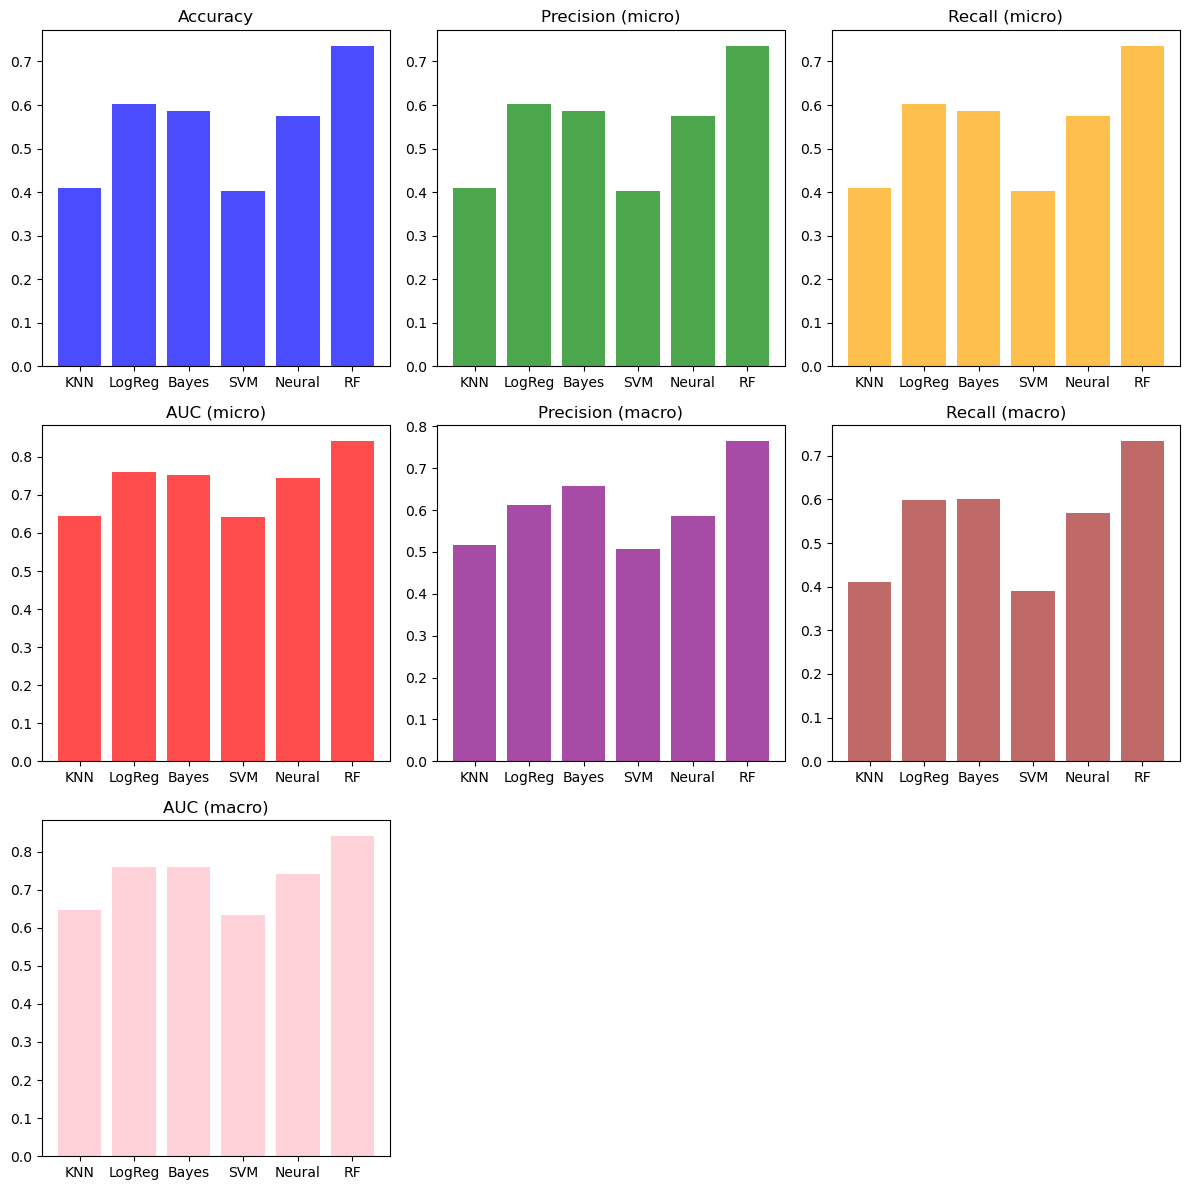

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Charger le dataset (assurez-vous que dataset_french est correctement défini)
df = dataset_french

# Diviser le dataset en features (X) et la target (y)
X = df['word_occurrences']
y = df['catégorie']

# Convertir les occurrences de mots en vecteurs
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(X)

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser les classifieurs
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'LogReg': LogisticRegression(random_state=42),
    'Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42),
    'Neural': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Comparaison des classifieurs
results = {'Classifier': [], 'Accuracy': [], 'Precision (micro)': [], 'Recall (micro)': [], 'AUC (micro)': [],
           'Precision (macro)': [], 'Recall (macro)': [], 'AUC (macro)': []}

# Définir une stratégie de validation croisée (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for clf_name, clf in classifiers.items():
    # Entraîner le classifieur sur l'ensemble d'entraînement
    clf.fit(X_train, y_train)
    
    # Prédire les catégories pour l'ensemble de test
    y_pred = clf.predict(X_test)
    
    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    roc_auc_micro = roc_auc_score(label_binarize(y_test, classes=clf.classes_), label_binarize(y_pred, classes=clf.classes_), average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    roc_auc_macro = roc_auc_score(label_binarize(y_test, classes=clf.classes_), label_binarize(y_pred, classes=clf.classes_), average='macro')
    
    # Stocker les résultats
    results['Classifier'].append(clf_name)
    results['Accuracy'].append(accuracy)
    results['Precision (micro)'].append(precision_micro)
    results['Recall (micro)'].append(recall_micro)
    results['AUC (micro)'].append(roc_auc_micro)
    results['Precision (macro)'].append(precision_macro)
    results['Recall (macro)'].append(recall_macro)
    results['AUC (macro)'].append(roc_auc_macro)

# Afficher les résultats
results_df = pd.DataFrame(results)

# Visualisation des résultats avec des barres
plt.figure(figsize=(12, 12))

# Accuracy
plt.subplot(3, 3, 1)
plt.bar(results_df['Classifier'], results_df['Accuracy'], color='blue', alpha=0.7)
plt.title('Accuracy')

# Precision (micro)
plt.subplot(3, 3, 2)
plt.bar(results_df['Classifier'], results_df['Precision (micro)'], color='green', alpha=0.7)
plt.title('Precision (micro)')

# Recall (micro)
plt.subplot(3, 3, 3)
plt.bar(results_df['Classifier'], results_df['Recall (micro)'], color='orange', alpha=0.7)
plt.title('Recall (micro)')

# AUC (micro)
plt.subplot(3, 3, 4)
plt.bar(results_df['Classifier'], results_df['AUC (micro)'], color='red', alpha=0.7)
plt.title('AUC (micro)')

# Precision (macro)
plt.subplot(3, 3, 5)
plt.bar(results_df['Classifier'], results_df['Precision (macro)'], color='purple', alpha=0.7)
plt.title('Precision (macro)')

# Recall (macro)
plt.subplot(3, 3, 6)
plt.bar(results_df['Classifier'], results_df['Recall (macro)'], color='brown', alpha=0.7)
plt.title('Recall (macro)')

# AUC (macro)
plt.subplot(3, 3, 7)
plt.bar(results_df['Classifier'], results_df['AUC (macro)'], color='pink', alpha=0.7)
plt.title('AUC (macro)')

plt.tight_layout()
plt.show()


c:\Users\samue\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\samue\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

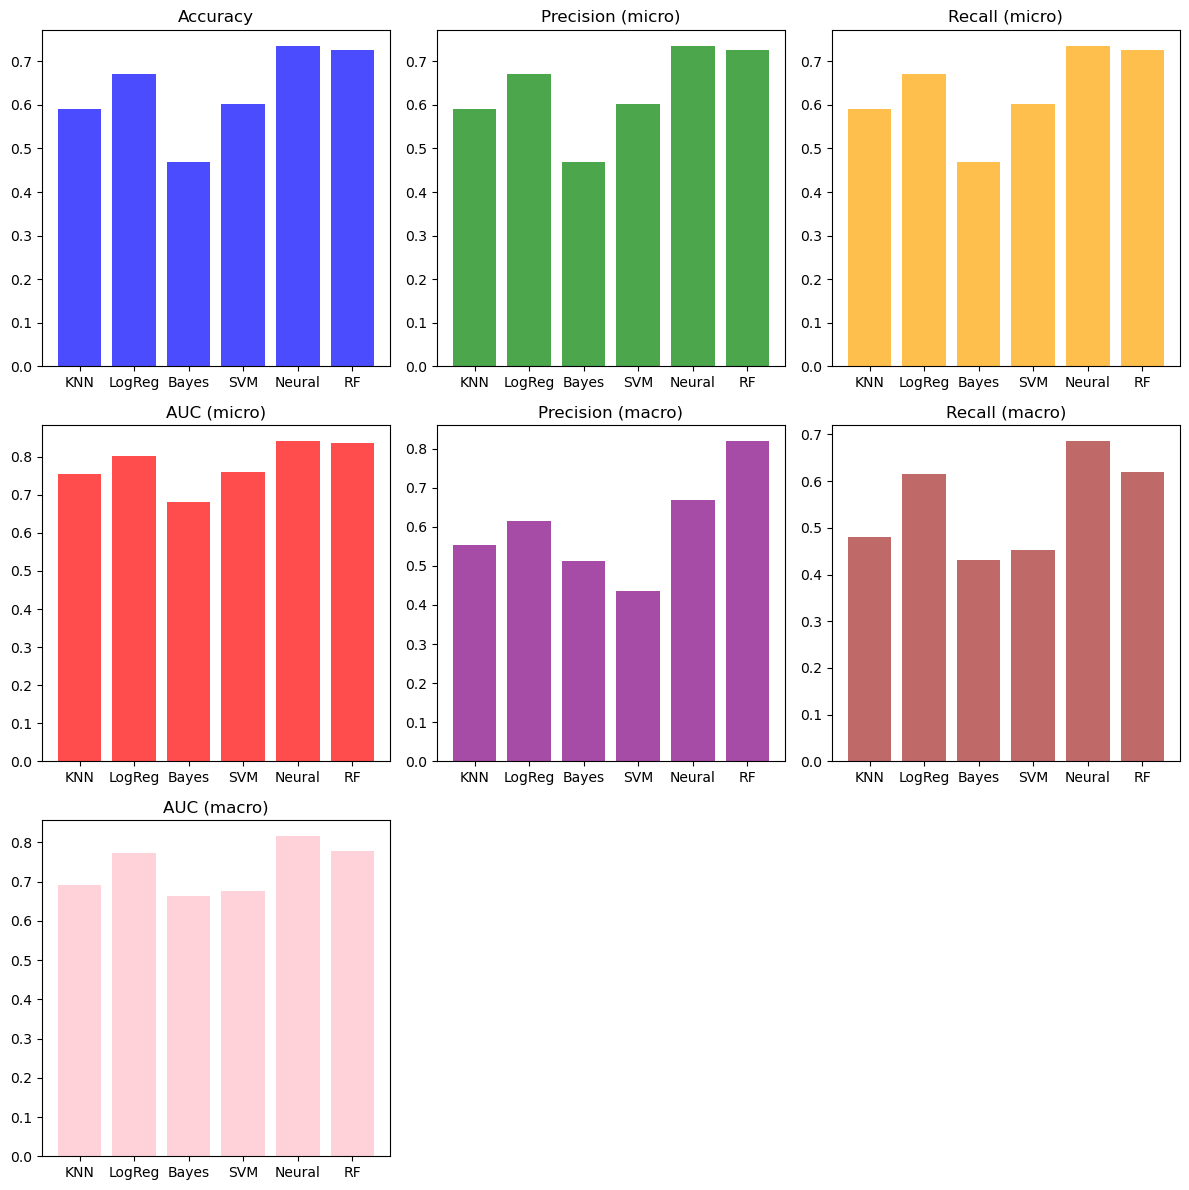

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Charger le dataset (assurez-vous que dataset_french est correctement défini)
df = dataset_english

# Diviser le dataset en features (X) et la target (y)
X = df['word_occurrences']
y = df['catégorie']

# Convertir les occurrences de mots en vecteurs
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(X)

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser les classifieurs
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'LogReg': LogisticRegression(random_state=42),
    'Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42),
    'Neural': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Comparaison des classifieurs
results = {'Classifier': [], 'Accuracy': [], 'Precision (micro)': [], 'Recall (micro)': [], 'AUC (micro)': [],
           'Precision (macro)': [], 'Recall (macro)': [], 'AUC (macro)': []}

# Définir une stratégie de validation croisée (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for clf_name, clf in classifiers.items():
    # Entraîner le classifieur sur l'ensemble d'entraînement
    clf.fit(X_train, y_train)
    
    # Prédire les catégories pour l'ensemble de test
    y_pred = clf.predict(X_test)
    
    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    roc_auc_micro = roc_auc_score(label_binarize(y_test, classes=clf.classes_), label_binarize(y_pred, classes=clf.classes_), average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    roc_auc_macro = roc_auc_score(label_binarize(y_test, classes=clf.classes_), label_binarize(y_pred, classes=clf.classes_), average='macro')
    
    # Stocker les résultats
    results['Classifier'].append(clf_name)
    results['Accuracy'].append(accuracy)
    results['Precision (micro)'].append(precision_micro)
    results['Recall (micro)'].append(recall_micro)
    results['AUC (micro)'].append(roc_auc_micro)
    results['Precision (macro)'].append(precision_macro)
    results['Recall (macro)'].append(recall_macro)
    results['AUC (macro)'].append(roc_auc_macro)

# Afficher les résultats
results_df = pd.DataFrame(results)

# Visualisation des résultats avec des barres
plt.figure(figsize=(12, 12))

# Accuracy
plt.subplot(3, 3, 1)
plt.bar(results_df['Classifier'], results_df['Accuracy'], color='blue', alpha=0.7)
plt.title('Accuracy')

# Precision (micro)
plt.subplot(3, 3, 2)
plt.bar(results_df['Classifier'], results_df['Precision (micro)'], color='green', alpha=0.7)
plt.title('Precision (micro)')

# Recall (micro)
plt.subplot(3, 3, 3)
plt.bar(results_df['Classifier'], results_df['Recall (micro)'], color='orange', alpha=0.7)
plt.title('Recall (micro)')

# AUC (micro)
plt.subplot(3, 3, 4)
plt.bar(results_df['Classifier'], results_df['AUC (micro)'], color='red', alpha=0.7)
plt.title('AUC (micro)')

# Precision (macro)
plt.subplot(3, 3, 5)
plt.bar(results_df['Classifier'], results_df['Precision (macro)'], color='purple', alpha=0.7)
plt.title('Precision (macro)')

# Recall (macro)
plt.subplot(3, 3, 6)
plt.bar(results_df['Classifier'], results_df['Recall (macro)'], color='brown', alpha=0.7)
plt.title('Recall (macro)')

# AUC (macro)
plt.subplot(3, 3, 7)
plt.bar(results_df['Classifier'], results_df['AUC (macro)'], color='pink', alpha=0.7)
plt.title('AUC (macro)')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier

# Supposons que vous ayez une nouvelle structure item-RSS appelée new_data
# new_data doit contenir un champ 'word_occurrences' similaire à votre ensemble d'entraînement

# Charger le meilleur classifieur RandomForest (assurez-vous de remplacer cela par votre meilleur classifieur)
best_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # Remplacez cela par votre meilleur classifieur

# Charger l'ensemble de données existant
existing_data = dataset_french

# Diviser l'ensemble de données existant en features (X) et la target (y)
X_existing = existing_data['word_occurrences']
y_existing = existing_data['catégorie']

# Convertir les occurrences de mots en vecteurs
vectorizer = DictVectorizer(sparse=False)
X_existing = vectorizer.fit_transform(X_existing)

# Entraîner le meilleur classifieur sur l'ensemble de données existant
best_classifier.fit(X_existing, y_existing)

# Supposons que new_data contienne un champ 'word_occurrences' similaire à votre ensemble d'entraînement
X_new = dataset_french['word_occurrences']

# Convertir les occurrences de mots en vecteurs (utilisez le même vectorizer)
X_new = vectorizer.transform(X_new)

# Prédire les catégories pour les nouvelles données
y_pred_new = best_classifier.predict(X_new)

# Obtenir les probabilités associées à chaque prédiction
probs_new = best_classifier.predict_proba(X_new)

# Afficher les résultats
print("Predicted:", list(y_pred_new))
print("Label Probability Prediction Order:", best_classifier.classes_)
print("Probs:", probs_new)
[11:57]
